In [68]:
import numpy as np
import matplotlib.pyplot as plt

# You may change the mhealth_activity module but your algorithm must support the original version
from mhealth_activity import Recording, Trace, Activity, WatchLocation, Path

# For interactive plots, uncomment the following line
# %matplotlib widget
import os
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
import scipy.stats as stats
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils     import check_random_state
from sklearn.metrics import mean_absolute_error,accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score, confusion_matrix,ConfusionMatrixDisplay
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import joblib

In [47]:
#read data
create_data_pickle = False
if create_data_pickle:
    files = os.listdir('data/train')
    list_of_dicts = []
    types_to_include = ['ax', 'ay', 'az', 'phone_ax', 'phone_ay', 'phone_az', 'speed', 'longitude', 'latitude', 'altitude', 'phone_steps']

    for file in tqdm(files):
        Dict = {}
        d = Recording(os.path.join('data/train',file))

        Dict['labels'] = d.labels
        for data_type in types_to_include:
            if data_type in d.data.keys():
                Dict[data_type] = d.data[data_type]
        list_of_dicts.append(Dict)

    data = pd.DataFrame(list_of_dicts)
    data.to_pickle(path='data/pickled_and_sorted_training_data.pkl.zst', compression={'method': 'zstd'})
else:
    data = pd.read_pickle('data/pickled_and_sorted_training_data.pkl.zst')
    data = data[['altitude','labels']]

In [48]:
#load pickled training 3d norm accelerometer data
import pickle
import pandas as pd

file = open('data/accel_mag_train.pkl', 'rb')
pickled = pickle.load(file)
accel_mag_train =  pd.DataFrame(((x,) for x in pickled), columns=['lists'])
print(accel_mag_train.shape)
file.close()

labels = []
for label in data["labels"]:
    labels.extend([[label["path_idx"],label["watch_loc"]]])
labels = pd.DataFrame(labels, columns =['path_idx', "smartwatch_location"])
# labels



(396, 1)


In [50]:
def features_extraction_common(inp): 
    df, prefix = inp
    FEATURES = ['Median', 'Numneg', 'Numpos', 'Numabovmed', 'Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Npeaks', 'avgprom', 'avgpeakdist', 'Sum_f', 'Max_f', 'NPeak_f', 'Avgprom_f','avgpeakdist_f', 'Mean_f', 'Skew_f', 'Kurtosis_f']

    for idx, feature in enumerate(FEATURES):
        FEATURES[idx] = FEATURES[idx] + '_' + prefix
    
    print(FEATURES)
    Median=[];Numneg=[];Numpos=[];Numabovmed=[];
    Min=[];Max=[];Mean=[];Mad=[];Sma=[];Eng=[];Iqr=[];Entr=[];Std=[];Var=[];Kurt=[];Skew=[];Npeaks=[];Avgprom=[]
    Min_d=[];Max_d=[];Mean_d=[];Mad_d=[];Sma_d=[];Eng_d=[];Iqr_d=[];Entr_d=[];Std_d=[];Var_d=[];
    Max_f=[];NPeak_f=[];Avgprom_f=[];Mean_f=[];Skew_f=[];Kurtosis_f=[];Sum_f=[]; Avgpeakdist=[]; Avgpeakdist_f=[];
    
    X = df.values
    ## TIME DOMAIN ##
    #list of lists of lists, ugly as fuck but it works 
    for recording in X:
        Median.append(np.median(recording[0]))
        Numneg.append(np.sum(np.array(recording[0]) < 0, axis=0))
        Numpos.append(np.sum(np.array(recording[0]) > 0, axis=0))
        Numabovmed.append(np.sum(np.array(recording[0]) > np.median(recording[0]), axis=0))

        Mean.append(np.mean(recording[0]))
        Std.append(np.std(recording[0]))
        #median absolute deviation
        Mad.append(stats.median_abs_deviation(recording[0], scale=1))
        Var.append(np.var(recording[0]))
        Min.append(np.min(recording[0]))
        Max.append(np.max(recording[0]))
        #Signal Magnitude Area
        Sma.append(np.sum(recording[0]))
        #energy measure
        Eng.append(np.sum(recording[0]**2)/len(recording[0]))
        Iqr.append(stats.iqr(recording[0]))
        Entr.append(stats.entropy(recording[0]))

        npeaks, _ = find_peaks(recording[0], distance=5)
        Npeaks.append(len(npeaks))
        prom = peak_prominences(recording[0], npeaks)
        Avgprom.append(np.mean(prom))

        Apeakdist = 0
        for i in range(len(npeaks)-1):
            Apeakdist += abs(npeaks[i] - npeaks[i+1])
        Avgpeakdist.append(Apeakdist/(len(npeaks)-1))

        ## FREQ DOMAIN ##
        ft = np.abs(fft(recording[0]))
        Sum_f.append(np.sum(ft))
        Max_f.append(np.max(ft))

        npeaks, _ = find_peaks(ft, distance=5)
        NPeak_f.append(len(npeaks))
        prom = peak_prominences(ft, npeaks)
        Avgprom_f.append(np.mean(prom))

        Apeakdist = 0
        for i in range(len(npeaks)-1):
            Apeakdist += abs(npeaks[i] - npeaks[i+1])
        Avgpeakdist_f.append(Apeakdist/(len(npeaks)-1))

        Mean_f.append(np.mean(ft))
        Skew_f.append(stats.skew(ft))
        Kurtosis_f.append(stats.kurtosis(ft))

    #Create dataframe from features
    df_features = pd.DataFrame(index = [FEATURES], 
                               data = [Median, Numneg, Numpos, Numabovmed, Mean,Std, Mad, Var, Min, Max, Sma, Eng, Iqr, Entr, Npeaks, Avgprom, Avgpeakdist, Sum_f, Max_f, NPeak_f, Avgprom_f, Avgpeakdist_f, Mean_f, Skew_f, Kurtosis_f]) 
    df_features = pd.DataFrame.transpose(df_features)
    df_features.columns = df_features.columns.map(''.join)
    # get rid of multiindex
    return df_features

# def features_extraction_path(df, prefix): 



In [55]:
#extract features from accelerometer norm and get rid of multiindex
accel_mag_features = features_extraction_common((accel_mag_train,"acc"))


['Median_acc', 'Numneg_acc', 'Numpos_acc', 'Numabovmed_acc', 'Mean_acc', 'STD_acc', 'MAD_acc', 'Var_acc', 'Min_acc', 'Max_acc', 'SMA_acc', 'Energy_acc', 'IQR_acc', 'Entropy_acc', 'Npeaks_acc', 'avgprom_acc', 'avgpeakdist_acc', 'Sum_f_acc', 'Max_f_acc', 'NPeak_f_acc', 'Avgprom_f_acc', 'avgpeakdist_f_acc', 'Mean_f_acc', 'Skew_f_acc', 'Kurtosis_f_acc']


In [22]:
# from scipy.signal import find_peaks
# altitude_gradients = []
# for sample in altitude_data:
#     altitude_gradients.append(np.gradient(sample))


def calc_altitude_features(df):
    FEATURES = ['min', 'max', 'amp', 'len', 'gain']
    for idx, feature in enumerate(FEATURES):
        FEATURES[idx] = FEATURES[idx] + '_alt' 
    
    
    Min=[]; Max=[]; amp=[];leng=[];gain=[]; segs =[]

    segfeats = []
    numsegs = 15
    for i in range(numsegs):
            segfeats.append(f"alt_seg{i}")
            segs.append([])

    X = df.values
    
    #list of lists of lists, ugly as fuck but it works 
    for recording in X:
        sos = signal.cheby2(1, 20, 0.5, 'lowpass', fs=12.5, output='sos')
        alt = signal.sosfiltfilt(sos,recording.values)

        Min.append(min(alt))
        Max.append(max(alt))
        #fit altitude data to a linear function to determine whether we are climbing or descending
        x = np.arange(0,len(alt),1)
        m,b = np.polyfit(x, alt, 1)
        amp.append(m*1000)
        leng.append(len(alt))
        gain.append(m*len(alt))
        df_features = pd.DataFrame(index = [FEATURES],  data = [Min, Max, amp, leng, gain])

        

        seglen = int(len(alt)/numsegs)
        for i in range(numsegs):
            segs[i].append(np.mean(alt[i*seglen : (i+1)*seglen]))

    

    segs = pd.DataFrame(index = [segfeats],  data = segs)
    segs = pd.DataFrame.transpose(segs)
    segs.columns = segs.columns.map(''.join)   

    df_features = pd.DataFrame.transpose(df_features)
    df_features.columns = df_features.columns.map(''.join)   
    df_features = pd.concat([df_features,  segs], axis=1)
    return df_features

 
features_alt = calc_altitude_features(data['altitude'])    
features_alt

,min_alt,max_alt,amp_alt,len_alt,gain_alt,alt_seg0,alt_seg1,alt_seg2,alt_seg3,alt_seg4,alt_seg5,alt_seg6,alt_seg7,alt_seg8,alt_seg9,alt_seg10,alt_seg11,alt_seg12,alt_seg13,alt_seg14
0,407.081550,452.780954,7.411320,7322.0,54.265689,410.906624,407.508446,408.459834,411.437609,416.791468,420.402792,423.886992,430.463897,437.156365,442.118415,444.066693,445.407671,447.418658,450.276806,452.043337
1,396.497460,450.299301,7.937385,6496.0,51.561256,405.306660,408.980027,409.758817,410.864707,413.093947,416.274006,419.800145,425.253137,429.765899,435.819892,439.796334,442.447243,442.805212,446.910872,450.206529
2,455.849271,502.491638,7.107153,7427.0,52.784824,456.326887,456.934843,457.433862,462.244247,469.537792,477.466575,483.178214,484.936209,484.794599,485.278747,489.660090,494.624250,497.532499,499.908418,502.099022
3,465.349484,500.666520,5.229312,6497.0,33.974841,466.523763,465.888387,466.284094,466.768276,468.489934,470.207899,473.183056,475.554008,474.334769,475.831202,480.327153,484.990605,489.072931,494.248939,499.262231
4,457.147142,501.817585,6.492793,7816.0,50.747671,457.463254,460.336281,461.815609,464.037534,468.555223,471.623896,476.951464,478.824766,479.929080,484.628763,489.599393,496.322909,499.033040,500.038069,500.660021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,405.250515,451.535211,-11.372012,4070.0,-46.284087,447.285838,448.155012,448.265969,449.274909,450.310407,450.549088,450.682110,446.289589,441.170206,438.832187,432.578756,424.213269,416.999603,409.971108,405.888180
392,404.167744,450.310347,-6.739805,7739.0,-52.159355,448.769937,449.510457,446.857901,443.700837,438.742115,431.932610,422.983121,416.660870,415.313992,414.094166,414.295970,413.420604,410.582349,406.880523,405.957837
393,456.285808,502.815407,5.716601,9347.0,53.433068,457.035727,457.715496,458.557206,462.434805,470.481000,473.759500,478.795168,482.504538,485.092655,488.018694,491.323447,493.905504,497.956676,500.730362,502.661872
394,454.110431,508.528037,-10.724878,5700.0,-61.131805,507.560000,504.332020,504.558385,500.855021,497.061817,498.863769,489.925680,484.519154,480.249406,477.145591,473.323335,467.457147,458.866930,456.972349,454.485123


In [79]:
watch_bearing_features = pd.read_pickle('data/watch_bearing_directions.pkl.zst')
phone_bearing_features = pd.read_pickle('data/phone_bearing_directions.pkl.zst')

total = pd.concat([features_alt, phone_bearing_features],axis=1)
# total = features_alt
# total = pd.concat([total, features_ax, features_ay,features_az],axis=1)
# phone_bearing_features

# total.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_names = total.columns
# print(feature_names)


        min_alt     max_alt    amp_alt  len_alt   gain_alt    alt_seg0  \
0    407.081550  452.780954   7.411320   7322.0  54.265689  410.906624   
1    396.497460  450.299301   7.937385   6496.0  51.561256  405.306660   
2    455.849271  502.491638   7.107153   7427.0  52.784824  456.326887   
3    465.349484  500.666520   5.229312   6497.0  33.974841  466.523763   
4    457.147142  501.817585   6.492793   7816.0  50.747671  457.463254   
..          ...         ...        ...      ...        ...         ...   
391  405.250515  451.535211 -11.372012   4070.0 -46.284087  447.285838   
392  404.167744  450.310347  -6.739805   7739.0 -52.159355  448.769937   
393  456.285808  502.815407   5.716601   9347.0  53.433068  457.035727   
394  454.110431  508.528037 -10.724878   5700.0 -61.131805  507.560000   
395  409.050853  452.025213   5.950452   7967.0  47.407251  409.715695   

       alt_seg1    alt_seg2    alt_seg3    alt_seg4  ...  avgdist3d_phone  \
0    407.508446  408.459834  411.4

RandomForestClassifier(n_estimators=125, n_jobs=-1, random_state=12)
0.775


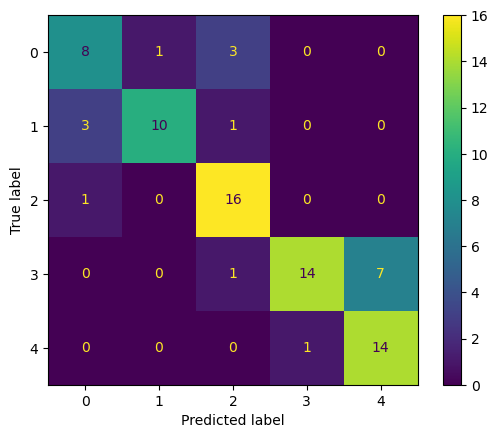

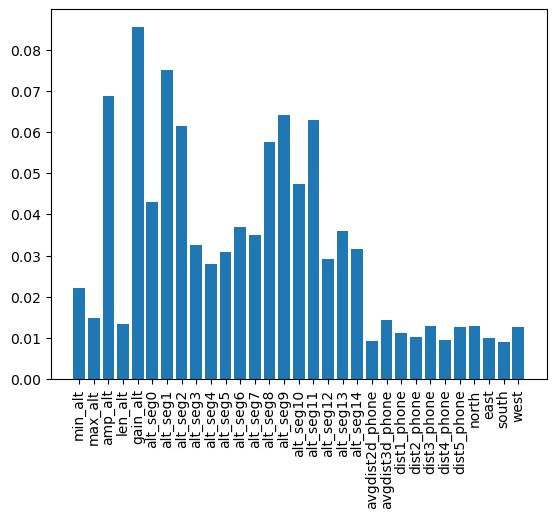

In [88]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

def split_and_train(X_train,y_train):
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=69)

    # Instantiate model with 1000 decision trees, use all cores
    rf = RandomForestClassifier(n_jobs=-1, random_state=12)
    param_dist = {'n_estimators':np.arange(50,500,25) }
    rand_search = GridSearchCV(rf, param_grid=param_dist, cv=5, n_jobs=-1)
    # rand_search = rf
    # Fit the random search object to the data
    rand_search.fit(X_train, y_train)
    y_pred = np.rint(rand_search.predict(X_test))

    # print(y_pred)
    return rand_search,y_pred,y_test,X_train,X_test,y_train

rf_model,y_pred,y_test,X_train,X_test,y_train = split_and_train(total,labels["path_idx"])

print(rf_model.best_estimator_)
print(accuracy_score(y_pred,y_test))
joblib.dump(rf_model, f"group32_model_path_id_acc{accuracy_score(y_pred,y_test)}.pkl") 


cmat = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cmat)
cm_display.plot()
plt.show() 

plt.bar(feature_names, rf_model.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.show()



In [16]:
def test_sensor_combinations():
    maxi = 0
    for i in range(1,16):
        feat = []
        print(i)
        print("[", end='')
        if(i&1):
            feat.append(features)
            print("features, ", end='')
        if(i&(1<<1)):
            feat.append(altitude_gradients)
            print("altitude_gradients, ", end='')
        if(i&(1<<2)):
            feat.append(labels["smartwatch_location"])
            print("smartwatch_location, ", end='')
        if(i&(1<<3)):
            feat.append(bearing_features)
            print("bearing_features, ", end='')
        print("]")
        feat = pd.concat(feat, axis=1)
        rf_model,y_pred,y_test,X_train,X_test = split_and_train(feat,labels["path_idx"])
        acc= accuracy_score(y_pred,y_test)
        if acc > maxi:
            maxi = acc
        print(acc)
    print(maxi)



test_sensor_combinations()

1
[features, ]


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=35)
0.3375
2
[altitude_gradients, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=40)
0.3875
3
[features, altitude_gradients, ]
RandomForestClassifier(n_jobs=-1, random_state=50)
0.525
4
[smartwatch_location, ]
RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=45)
0.1875
5
[features, smartwatch_location, ]
RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=45)
0.3
6
[altitude_gradients, smartwatch_location, ]
RandomForestClassifier(n_jobs=-1, random_state=40)
0.4875
7
[features, altitude_gradients, smartwatch_location, ]
RandomForestClassifier(n_estimators=350, n_jobs=-1, random_state=40)
0.4375
8
[bearing_features, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=40)
0.125
9
[features, bearing_features, ]
RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=55)
0.3125
10
[altitude_gradients, bearing_features, ]
RandomForestClassifier(n_estimator

In [14]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)
feature_list = ['Mean', 'STD', 'MAD', 'Var', 'Min', 'Max', 'SMA', 'Energy', 'IQR', 'Entropy', 'Sum_f', 'Max_f', 
                'Peak_f', 'Peak_i_f', 'Mean_f', 'Skew_f', 'Kurtosis_f', 'Mean_d', 'STD_d', 'MAD_d', 'Var_d', 'Min_d', 
                'Max_d', 'SMA_d', 'Energy_d', 'IQR_d', 'Entropy_d','slopes']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

In [13]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

NameError: name 'importances' is not defined

In [112]:
print(data["labels"].loc[10])
d = Recording("data/train/train_trace_010.pkl")
print(d.labels)

print(labels["path_idx"][10])

{'path_idx': 0, 'activities': [1], 'step_count': None, 'watch_loc': 2}
{'path_idx': 0, 'activities': [1], 'step_count': None, 'watch_loc': 2}
0
